Created by: William Chour

This Jupyter notebook enables the user to analyze protein gels for band intensities. Input file should be a raw16 TIF file of the protein gel. Output files will consist of a csv containing gel band intensity measurements, and a png file highlighting identified bands. 

To run the code, the user simply needs to load all cells below this notebook. Then, run the function process_protein_gel(), inputting the appropriate parameters as shown in the example lines provided.

In [1]:
import numpy as np
import pandas as pd
import glob, os

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation
from skimage import exposure

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from skimage import data
'''
IMPORTANT: scikit-image module must be 0.15.0 or earlier
'''
import cv2

In [2]:
def define_rect(image):
    """
    Define a rectangular window by clicking and dragging your mouse.

    Parameters
    ----------
    image: Input image.
    """

    clone = image.copy()
    clone = exposure.adjust_gamma(clone, 0.5)
    rect_pts = [] # Starting and ending points
    win_name = "image" # Window name
    box = []

    def select_points(event, x, y, flags, param):
        
        nonlocal rect_pts
        nonlocal box
        if event == cv2.EVENT_LBUTTONDOWN:
            box = [(x,y)]
            rect_pts.append((x, y))

        if event == cv2.EVENT_LBUTTONUP:
            box.append((x,y))
            rect_pts.append((x, y))
            cv2.rectangle(clone, box[0], box[1], color = 16777215, thickness = 2)
            cv2.imshow(win_name, clone)

    cv2.namedWindow(win_name, flags=cv2.WINDOW_NORMAL)
    cv2.setMouseCallback(win_name, select_points)
        

    while True:
        # display the image and wait for a keypress
        cv2.imshow(win_name, clone)
        key = cv2.waitKey(0) & 0xFF

        if key == ord("r"): # Hit 'r' to replot the image & reset points
            clone = image.copy()
            rect_pts = []

        elif key == ord("c"): # Hit 'c' to confirm the selection
            break

    # close the open windows
    cv2.destroyWindow(win_name)

    return rect_pts

In [3]:
def process_band_intensity(top_left_coords, bot_right_coords, raw_image, mode):
    """
    Calculate band intensity of selected band.

    Parameters
    ----------
    top_left_coords: (x0,y0), location of upper left corner of rectangle containing band.
    bot_right_coords: (x1,y1), location of lower right corner of rectangle containing band.
    raw_image: image file from which crops are extracted.
    mode: 'raw' or 'sub' for total intensity calculation from raw or background-subtracted image, respectively.
        This value is entered from initiation of function 'process_protein_gel'.
    """
    # Take in raw image from arguments.
    image = raw_image
    # Save corner coordinates of boxed region.
    x0, y0, x1, y1 = top_left_coords[0], top_left_coords[1], bot_right_coords[0], bot_right_coords[1]
    
    # Prepare a sliced array using coordinates.
    slc = np.s_[y0:y1, x0:x1]
    
    # Slice out band from image.
    im_phase = image[slc]
    
    # Image processing steps...
    # Structuring element
    selem = skimage.morphology.square(3)

    # Perform median filter
    im_phase_filt = skimage.filters.median(im_phase, selem)
    
    # Apply a gaussian blur with a 50 pixel radius. 
    im_phase_gauss = skimage.filters.gaussian(im_phase_filt, 50.0)
    
    # Convert the median-filtered phase image to a float64
    im_phase_float = skimage.img_as_float(im_phase_filt)

    # Subtract our gaussian blurred image from the original.
    im_phase_sub = im_phase_float - im_phase_gauss
    
    # Compute Otsu threshold value for median filtered image
    thresh_otsu = skimage.filters.threshold_otsu(im_phase_sub)
    
    # Construct thresholded image
    im_bw = im_phase_sub > thresh_otsu
    
    # Label binary image; background kwarg says value in im_bw to be background
    im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)
    
    # Show number of regions
    print('Number of individual regions = ', n_labels)
    
    # Extract region props
    if mode == 'raw':
        im_props = skimage.measure.regionprops(im_labeled, intensity_image=im_phase, coordinates = 'xy')
    if mode == 'sub':
        im_props = skimage.measure.regionprops(im_labeled, intensity_image=im_phase_sub, coordinates = 'xy')

    
    # Make a filtered black and white image
    im_bw_filt = im_labeled > 0

    # Define cutoff size
    cutoff_size = 100
    cutoff_mean_intensity = 0.002

    # Identified bands must meet two criteria. 1) They must be larger than cutoff size. 2) The mean intensity 
    # must be larger than a certain value. The mean intensity cutoff ensures that background shapes from the 
    # gel do not get picked up as bands.
    n_regions = 0
    for prop in im_props:
        if prop.area < cutoff_size or prop.mean_intensity < cutoff_mean_intensity:
            im_bw_filt[im_labeled==prop.label] = 0
        # if prop.area > (0.8*(y1-y0)*(x1-x0)):
            #im_bw_filt[im_labeled==prop.label] = 0
        else:
            n_regions += 1
    print('Number of individual regions after small object deletion = ', n_regions)
    
    # Initialize list of intensities of individual bacteria
    int_intensity = []
    int_density = []

    # Loop through regions and compute integrated intensity of bacteria. Normally, we would also calculate
    # intensity of regions which fall below cutoff_mean_intensity. But for cleaner data, we set those 
    # intensities to 0. These samples will most likely give no SCT expression, and therefore will give no yield.
    for prop in im_props:
        if prop.area > cutoff_size: # and prop.eccentricity > 0.8:
            int_density.append(prop.mean_intensity)
            if prop.mean_intensity > cutoff_mean_intensity:
                int_intensity.append(prop.area * prop.mean_intensity)
            else:
                int_intensity.append(0)

    # Round sum value and then convert to an int. If there is no band present, store intensity as zero value.
    int_intensity = np.rint(int_intensity).astype(int)
    if np.any(int_intensity) != 0:
        int_intensity = int(np.max(int_intensity))
    else:
        int_intensity = 0
    
    # Take a look
    print('Total band intensity = ' + str(int_intensity))
    return int_intensity, im_phase, im_bw_filt, int_density

In [4]:
def process_protein_gel(*args, band_range = (1,4), ctrl_band = 1, label = [],
                        image_name = '', mode = 'raw', ref_abs = 1.222, ref_ext_coeff = 100530, 
                        ref_mw = 50150, ref_ul = 3, sample_ul = 15):
    # Store image name as a strings, raw16 for analysis & w/o raw16 for visualization.
    image_string = str(image_name)
    # image_string_for_rect = image_string.replace('.raw16', '')
    first_band, last_band = band_range[0], band_range[1]
    
    # If no image name given, prompt user to provide name.
    if image_string == '':
        image_string = input("What is image file name (tif file in raw16 format)? ")
        
    # If user provides file w/o raw16 format, stop function and prompt submission in correct format.
    if '.raw16' in image_string:
        print('')
    else:
        print('Ensure that that image_name is in raw16 tif file format')
        return
    
    # Read in images for both formats.
    image = skimage.io.imread(image_string)
    # image_for_rect = skimage.io.imread(image_string_for_rect)
    
    # Select rectanges for each band and store corner coordinates to an array.
    bands = define_rect(image)
    
    # Identify min max x-y coordinates from the selected bands.
    x, y = zip(*bands)
    x_min, x_max, y_min, y_max = np.min(x), np.max(x), np.min(y), np.max(y)
    box = x_min, x_max, y_min, y_max
    
    # Determine total # of bands based on # of saved coordinates (2 coordinates per band).
    number_bands = int(np.shape(bands)[0]/2)

    # Determine length of x-axis for rect_image by obtaining dimensions.
    rect_image_dim = np.shape(image[y_min:y_max, x_min:x_max])
    x_length = rect_image_dim[1]
    
    '''

    x_label = []
    # Create array of strings to hold x-axis labels.
    if label == []:
        for i in range(first_band, last_band+1):
            x_label.append(str(i))
        x_label = np.insert(x_label, ctrl_band-1, 'C')
    else:
        x_label = label
    '''
    
    # Initiate variables to store intensity, raw image data, and filtered image data.
    band_intensities = []
    raw_images = []
    filt_images = []
    band_densities = []
    
    # For each band, calculate band intensity and store output data to respective arrays.
    for i in range(number_bands):
        a, b, c, d = process_band_intensity(bands[i*2], bands[i*2+1], image, mode)
        band_intensities.append(a)
        raw_images.append(b)
        filt_images.append(c)
        band_densities.append(d)

    # Set up a grid plot to visualize the raw gel and the filtered, identified bands.     
    with sns.axes_style('dark'):
        fig = plt.figure(1)
        grid = plt.GridSpec(2, number_bands)
        # large subplot in upper half of the image, to show the entire span of raw data covering the bands
        plt.subplot2grid((2, number_bands), (0,0), colspan=number_bands, rowspan=1)
        plt.imshow(image[y_min:y_max, x_min:x_max], cmap=plt.cm.gray)
        #plt.title('Normal distribution')
        
        # Set x ticks under the main gel to display the well ID.
        plt.xticks(np.arange(x_length/(2*number_bands), x_length, step = x_length/number_bands), 
                       label, fontsize=30)    
        plt.gca().get_yaxis().set_ticklabels([])
        
        # To display subplots of identified bands from filtered image, loop through each band entry and plot corresponding filtered image coordinates.
        for i in range(number_bands):
            plt.subplot2grid((2, number_bands), (1,i))
            plt.imshow(filt_images[i])
            # plt.title(x_label[i], fontsize=30)
            plt.gca().get_xaxis().set_ticklabels([])
            plt.gca().get_yaxis().set_ticklabels([])
            #ax1 = plt.axes()
            #ax1.axes.get_yaxis().set_visible(False)
    
    # Save image to png.
    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    fig.set_size_inches(w=21,h=7)
    fig_name = image_string + '_' + mode + '.png'
    fig.savefig(fig_name)    
    
    
    # Create zero matrix for calculation of normalized intensities of each sample.
    norm_intensities = np.zeros(number_bands)
    
    # Loop through each band intensity value and normalize it against the intensity of the control lane.
    for i in range(len(band_intensities)):
        print(band_intensities[i])
        print(band_intensities[ctrl_band-1])
        print()
        norm_intensities[i] = band_intensities[i]/band_intensities[ctrl_band-1]
        
    # Convert the norm_intensities array to a list for integration into DataFrame.
    norm_intensities = norm_intensities.tolist()
    
    # Calculate the multiplier for conversion of each normalized band intensity to protein yield.
    ctrl_mass_ug = ref_abs/ref_ext_coeff*ref_mw*ref_ul
    print(ctrl_mass_ug)
    
    # Calculate sample yield based on multiplier. First create zero matrix array to hold yield values.
    sample_yield = np.zeros(len(norm_intensities))
    
    # Loop through normalized intensities matrix. For every value, multiply by multiplier, and divide by the sample volume loaded to obtain mg/ml.
    for i in range(len(norm_intensities)):
        sample_yield[i] = (norm_intensities[i]*ctrl_mass_ug/sample_ul)
    sample_yield[ctrl_band-1] = ctrl_mass_ug/ref_ul
    
    # A more realistic representation of yield is mg/L, so create new array to hold converted values.
    sample_yield_mg_per_liter = sample_yield*1000
    

    # Save all the relevant data points to an array, then convert to DataFrame for export as csv.
    data = [label, band_intensities, norm_intensities, band_densities, sample_yield, sample_yield_mg_per_liter]
    df = pd.DataFrame(data=data)
    df_T = df.transpose()
    df_T.to_csv(image_string + '_' + mode + '.csv', sep='\t', encoding='utf-8', index=False, 
                header=('label', 'band_intensities', 'norm_intensities', 'band_densities', 'sample_yield', 'sample_yield_mg_per_liter'))
    
    
    # Return band intensities as an array.
    # return x_label, band_intensities, norm_intensities
    return label, band_intensities, norm_intensities

In [5]:
print(np.arange(1, 94))
test = np.arange(1, 94)
data = []
for i in test:
    data.append(str(i))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]


In [6]:
data

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93']


Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 51
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 46
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 37
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 56
Number of individual regions =  11
Number of individual regions after small object deletion =  1
Total band intensity = 7
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 31
Number of individual regions =  12
Number of individual regions after small object deletion =  1
Total band intensity = 12
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 64
Number of individual r

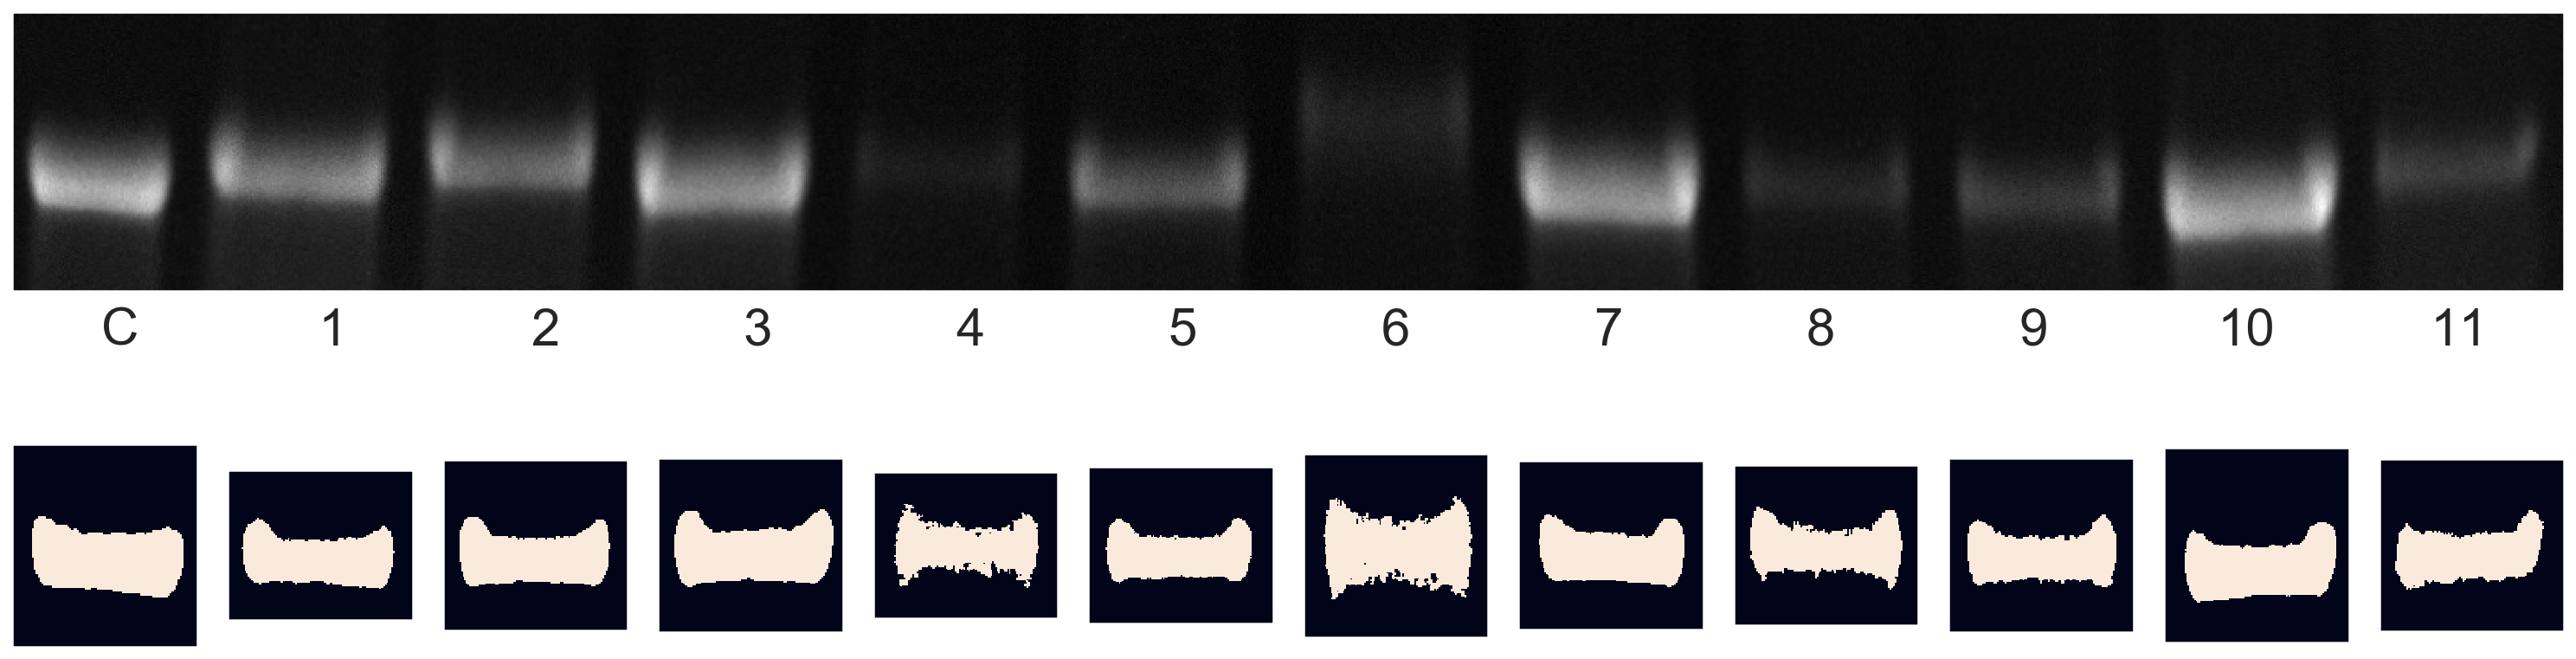

In [9]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h25m01s(Stain Free Gel) 200829 tfxn med r 1-11.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C','1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4496), equivalent to an approximate bitdepth of 12.1.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1074), equivalent to an approximate bitdepth of 10.1.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1380), equivalent to an approximate bitdepth of 10.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1807), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 76
Number of individual regions =  25
Number of individual regions after small object deletion =  1
Total band intensity = 6
Number of individual regions =  4
Number of individual regions after small object deletion =  1
Total band intensity = 12
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 20
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 11
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 34
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 20
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 105
Number of individual re

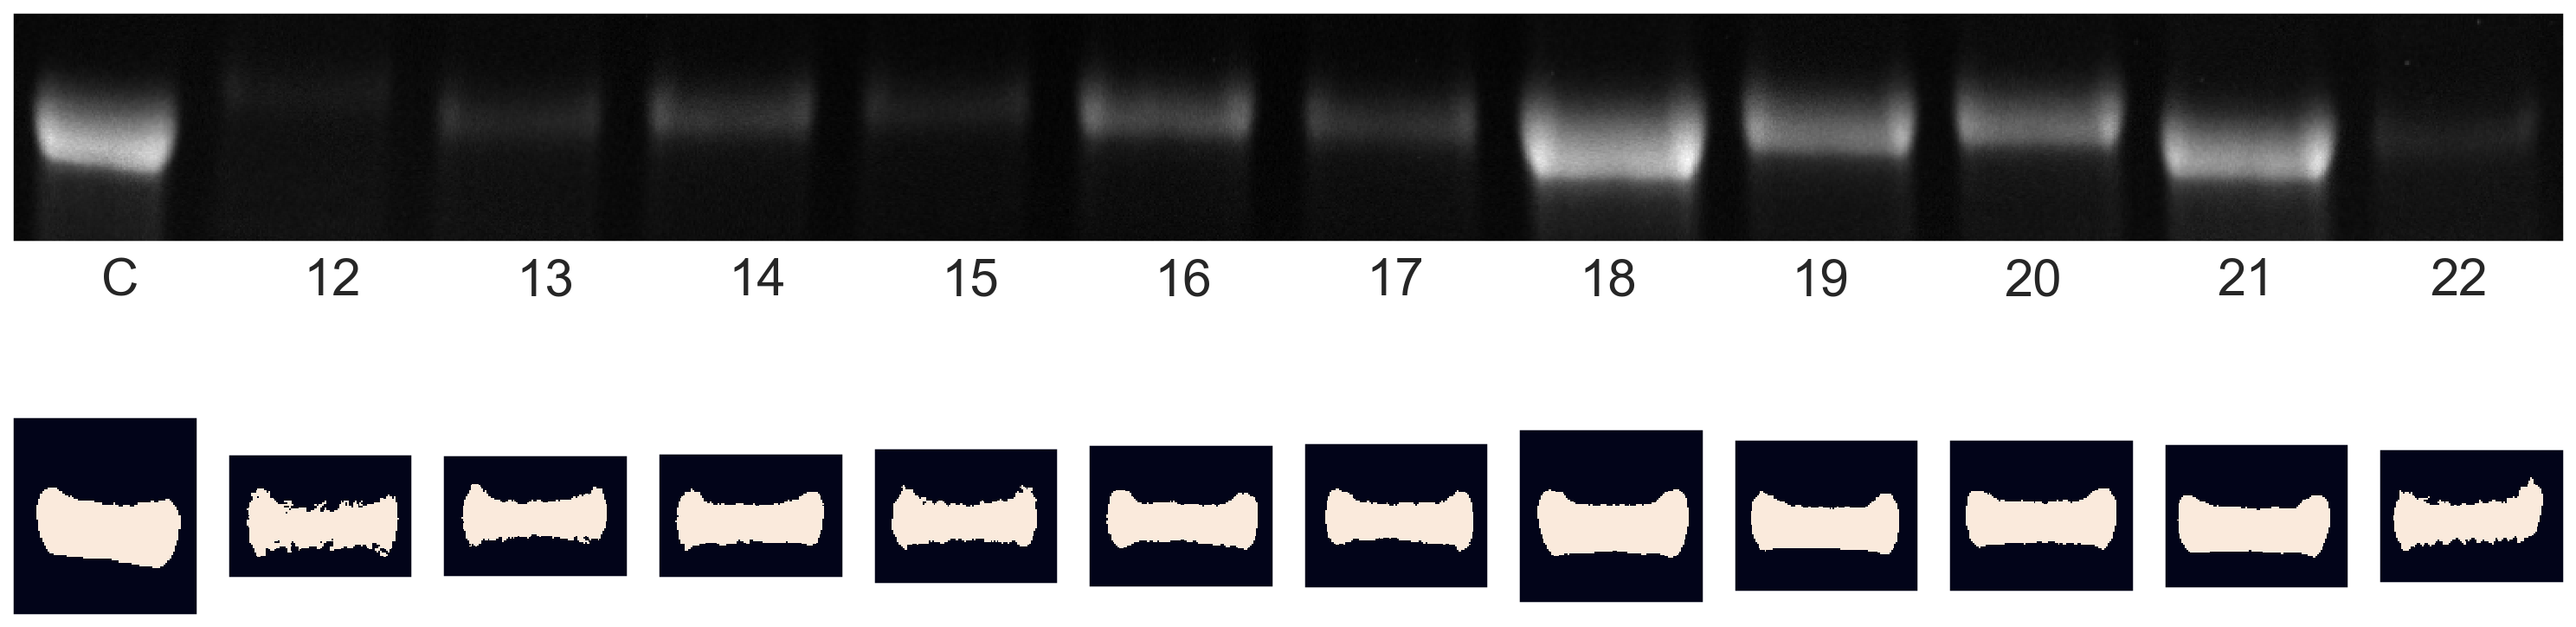

In [10]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h27m04s(Stain Free Gel) 200829 tfxn med r 12-22.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4775), equivalent to an approximate bitdepth of 12.2.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2993), equivalent to an approximate bitdepth of 11.5.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1310), equivalent to an approximate bitdepth of 10.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4658), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 81
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 43
Number of individual regions =  9
Number of individual regions after small object deletion =  1
Total band intensity = 16
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 91
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 12
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 21
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 82
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 19
Number of individual reg

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1486), equivalent to an approximate bitdepth of 10.5.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


 1
Total band intensity = 10
81
81

43
81

16
81

91
81

12
81

21
81

82
81

19
81

0
81

10
81

18
81

10
81

1.8288063264697105


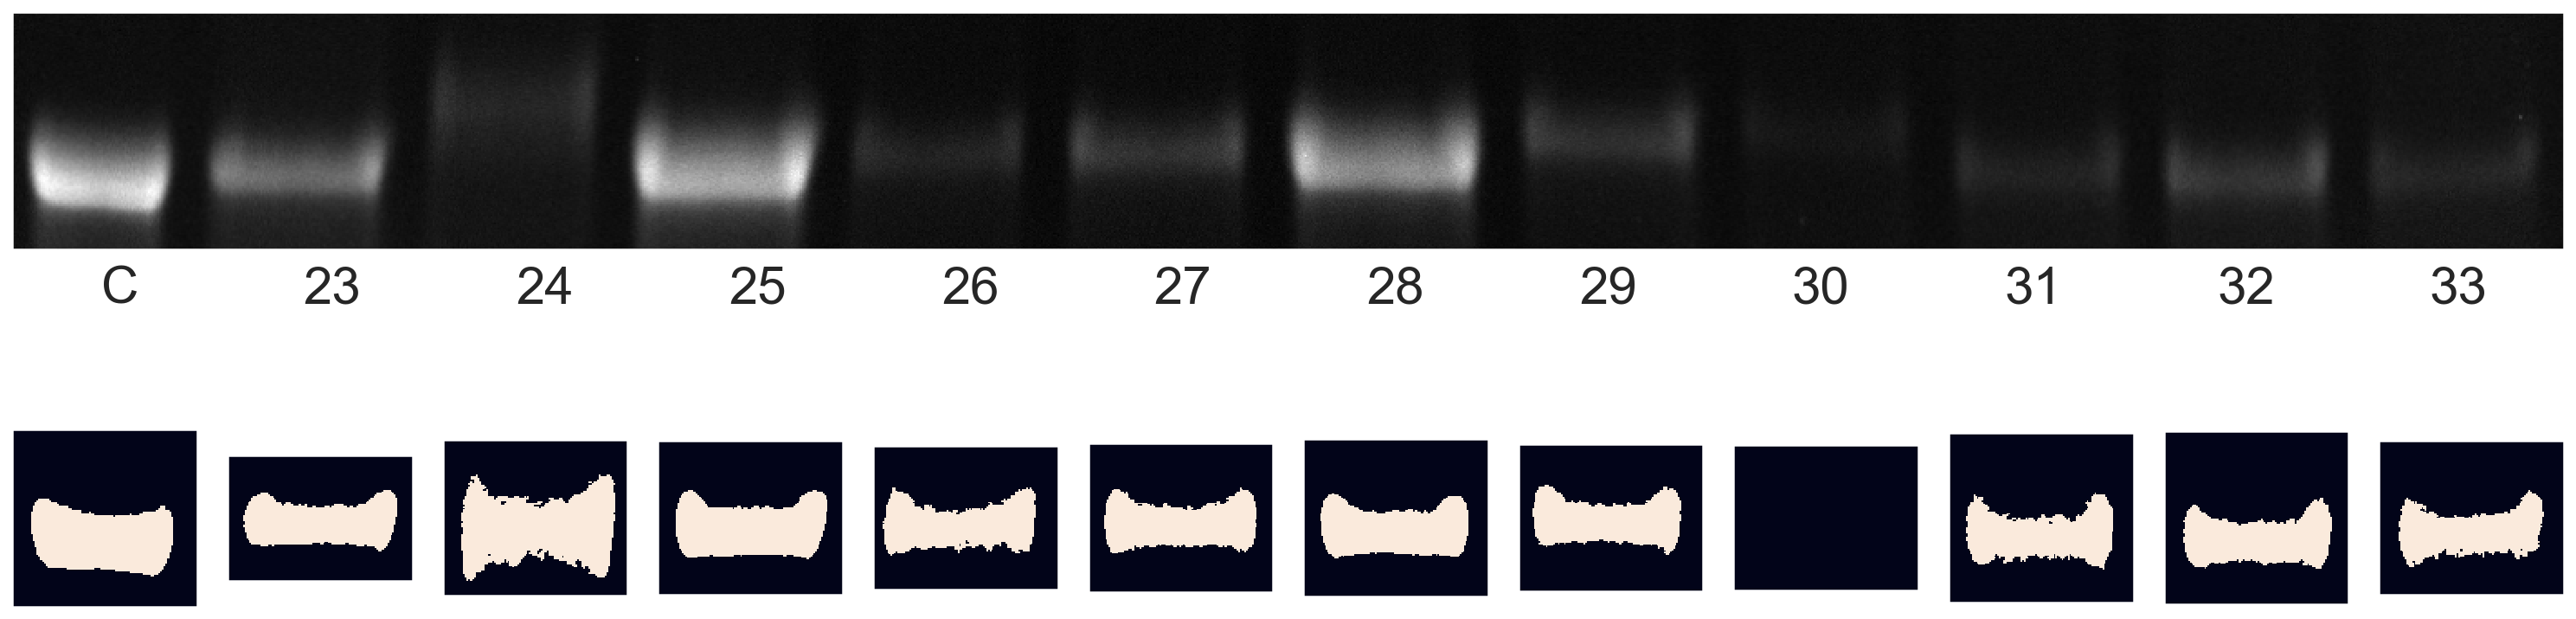

In [11]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h28m51s(Stain Free Gel) 200829 tfxn med r 23-33.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5140), equivalent to an approximate bitdepth of 12.3.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2495), equivalent to an approximate bitdepth of 11.3.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2060), equivalent to an approximate bitdepth of 11.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5490), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 88
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 31
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 21
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 109
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 61
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 50
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 74
Number of individual regions =  4
Number of individual regions after small object deletion =  1
Total band intensity = 9
Number of individual reg

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1716), equivalent to an approximate bitdepth of 10.7.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


 1
Number of individual regions after small object deletion =  1
Total band intensity = 16
88
88

31
88

21
88

109
88

61
88

50
88

74
88

9
88

43
88

17
88

88
88

16
88

1.8288063264697105


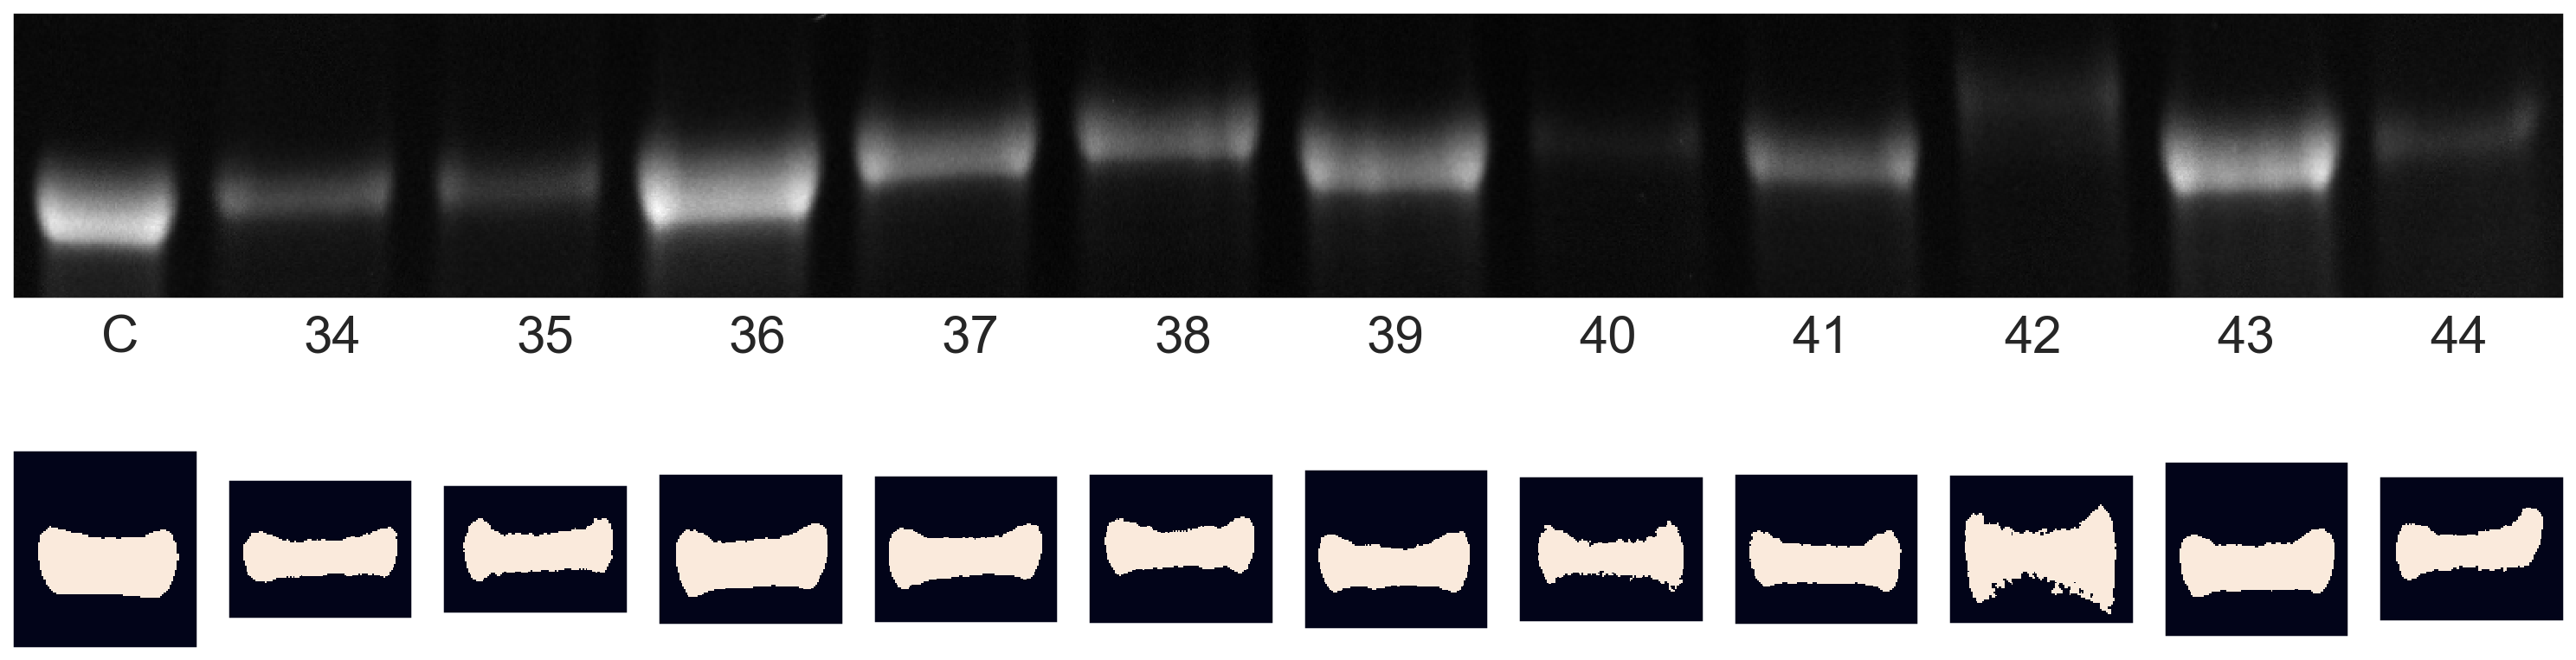

In [12]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h30m38s(Stain Free Gel) 200829 tfxn med r 34-44.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5514), equivalent to an approximate bitdepth of 12.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (6890), equivalent to an approximate bitdepth of 12.8.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5943), equivalent to an approximate bitdepth of 12.5.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2254), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 90
Number of individual regions =  2
Number of individual regions after small object deletion =  1
Total band intensity = 27
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 109
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 28
Number of individual regions =  17
Number of individual regions after small object deletion =  1
Total band intensity = 7
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 15
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 28
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 15
Number of individual re

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4142), equivalent to an approximate bitdepth of 12.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


Number of individual regions after small object deletion =  1
Total band intensity = 69
90
90

27
90

109
90

28
90

7
90

15
90

28
90

15
90

42
90

28
90

114
90

69
90

1.8288063264697105


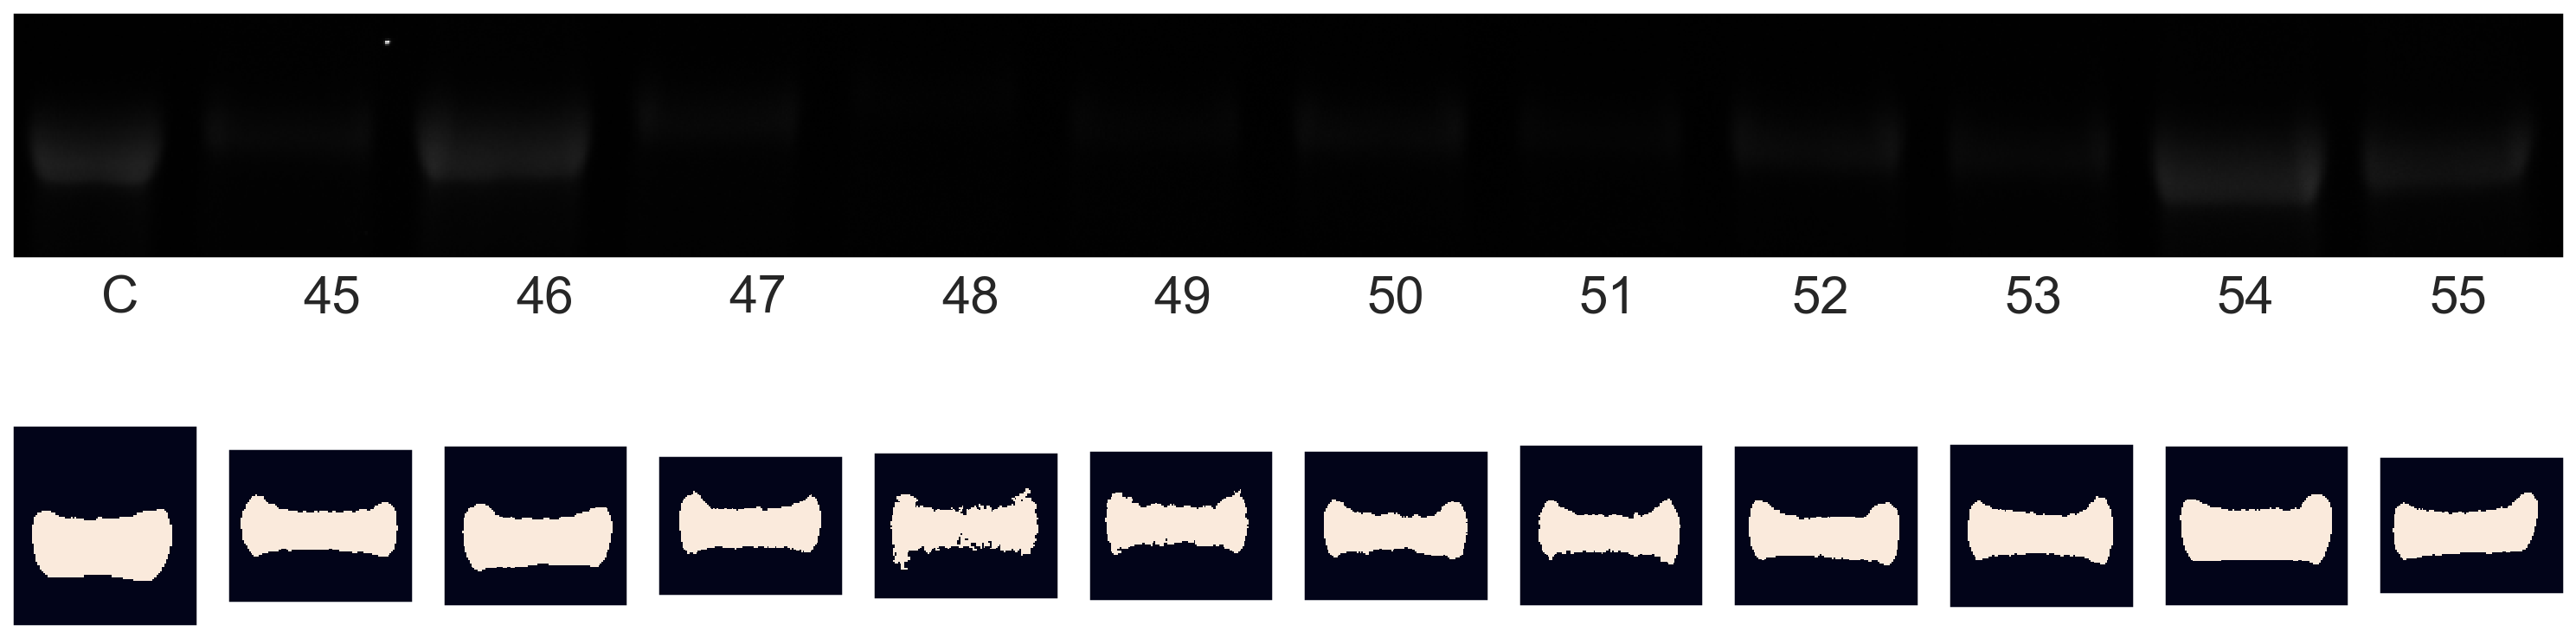

In [13]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h32m15s(Stain Free Gel) 200829 tfxn med r 45-55.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5503), equivalent to an approximate bitdepth of 12.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4696), equivalent to an approximate bitdepth of 12.2.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4928), equivalent to an approximate bitdepth of 12.3.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4280), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 93
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 78
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 90
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 71
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 81
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 57
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 89
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 99
Number of individual reg

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4005), equivalent to an approximate bitdepth of 12.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4837), equivalent to an approximate bitdepth of 12.2.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5273), equivalent to an approximate bitdepth of 12.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


 1
Number of individual regions after small object deletion =  1
Total band intensity = 77
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 101
93
93

78
93

90
93

71
93

81
93

57
93

89
93

99
93

108
93

62
93

77
93

101
93

1.8288063264697105


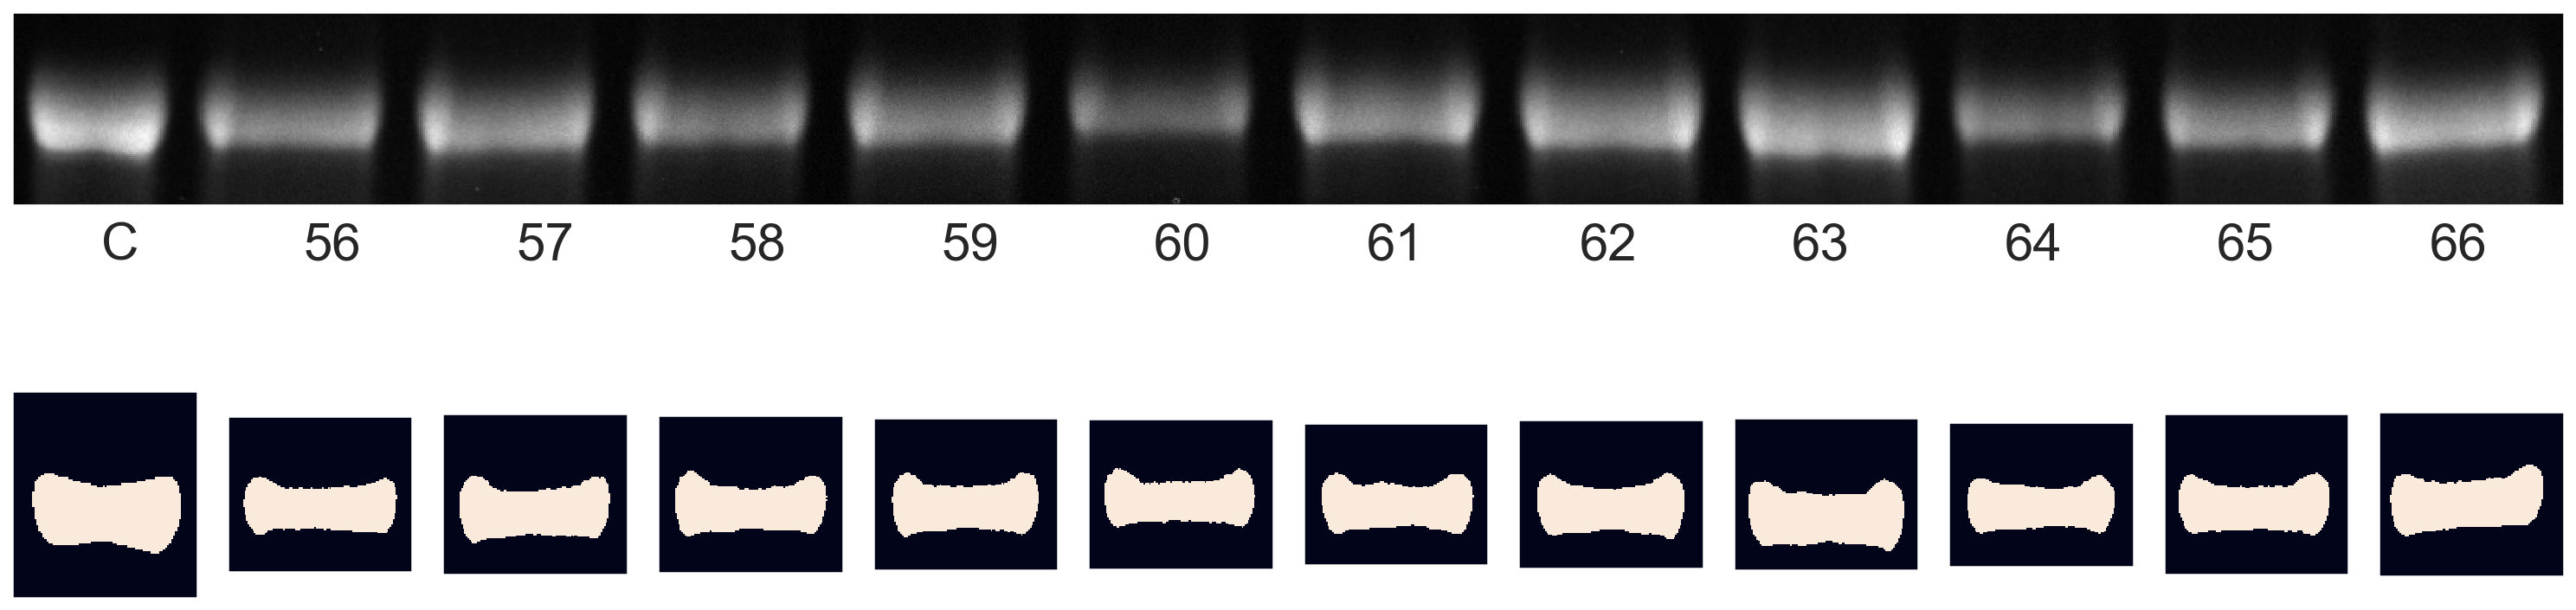

In [14]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h34m07s(Stain Free Gel) 200829 tfxn med r 56-66.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5014), equivalent to an approximate bitdepth of 12.3.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (3454), equivalent to an approximate bitdepth of 11.8.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (3680), equivalent to an approximate bitdepth of 11.8.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2604), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 88
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 58
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 66
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 45
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 73
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 82
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 105
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 73
Number of individual re

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4543), equivalent to an approximate bitdepth of 12.1.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4890), equivalent to an approximate bitdepth of 12.3.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


88
88

58
88

66
88

45
88

73
88

82
88

105
88

73
88

88
88

98
88

81
88

97
88

1.8288063264697105


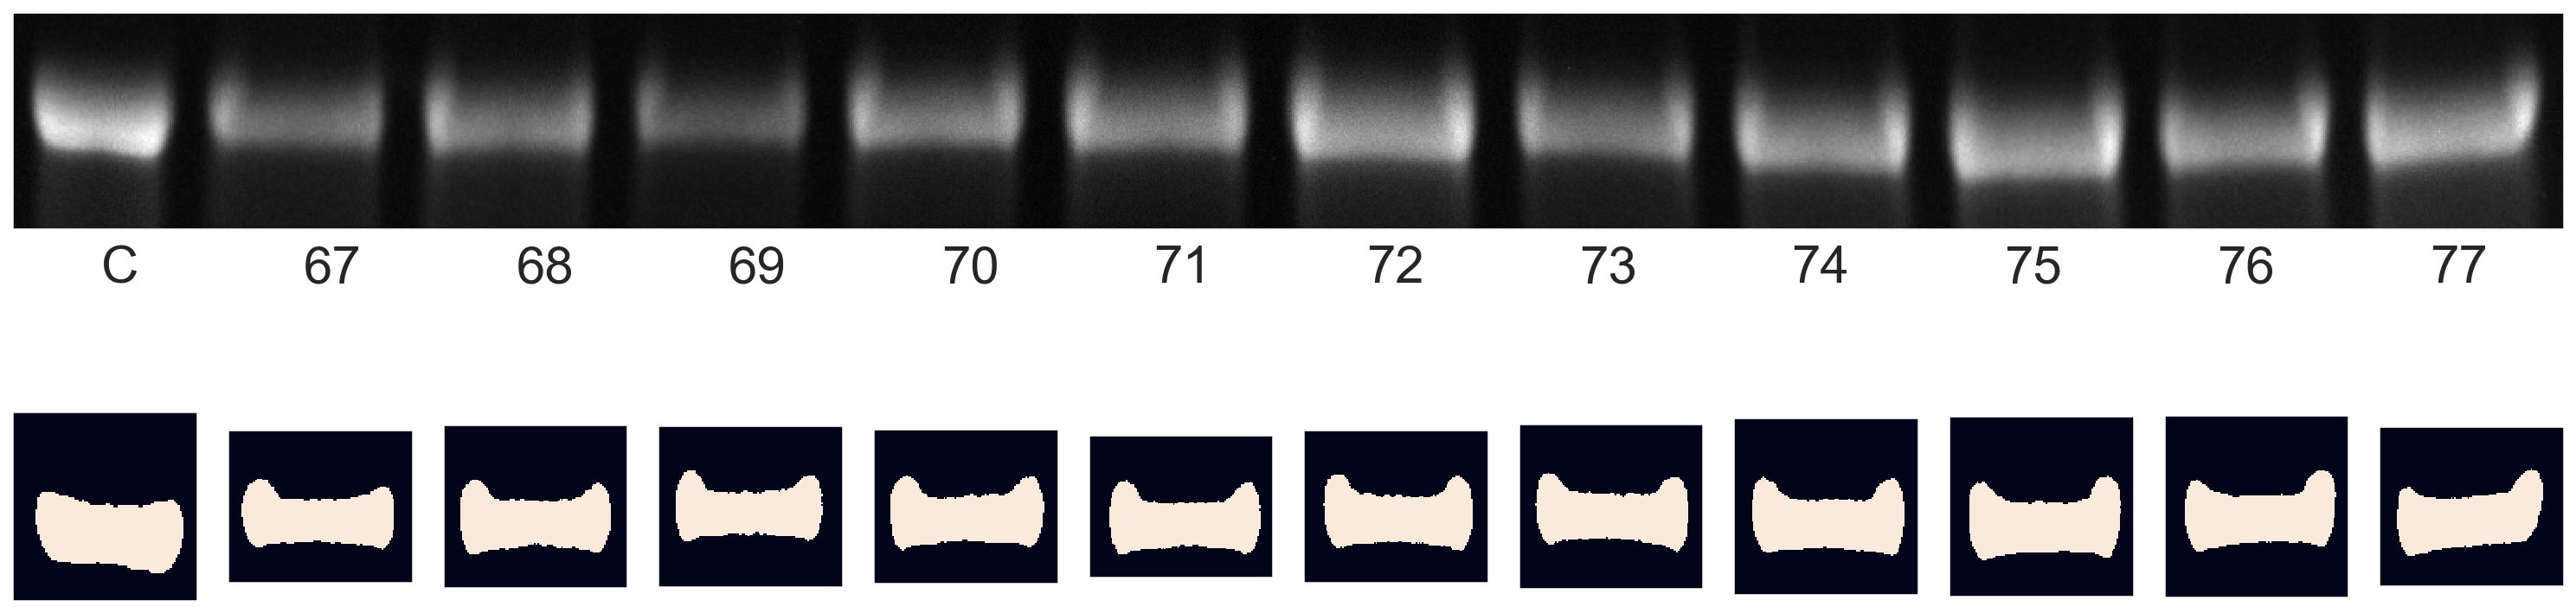

In [15]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h36m15s(Stain Free Gel) 200829 tfxn med r 67-77.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5444), equivalent to an approximate bitdepth of 12.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (3478), equivalent to an approximate bitdepth of 11.8.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5539), equivalent to an approximate bitdepth of 12.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5884), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 93
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 56
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 105
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 123
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 119
Number of individual regions =  5
Number of individual regions after small object deletion =  1
Total band intensity = 15
Number of individual regions =  97
Number of individual regions after small object deletion =  0
Total band intensity = 0
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 22
Number of individual 

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1985), equivalent to an approximate bitdepth of 11.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1796), equivalent to an approximate bitdepth of 10.8.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


 1
Number of individual regions after small object deletion =  1
Total band intensity = 22
Number of individual regions =  2
Number of individual regions after small object deletion =  1
Total band intensity = 18
93
93

56
93

105
93

123
93

119
93

15
93

0
93

22
93

18
93

0
93

22
93

18
93

1.8288063264697105


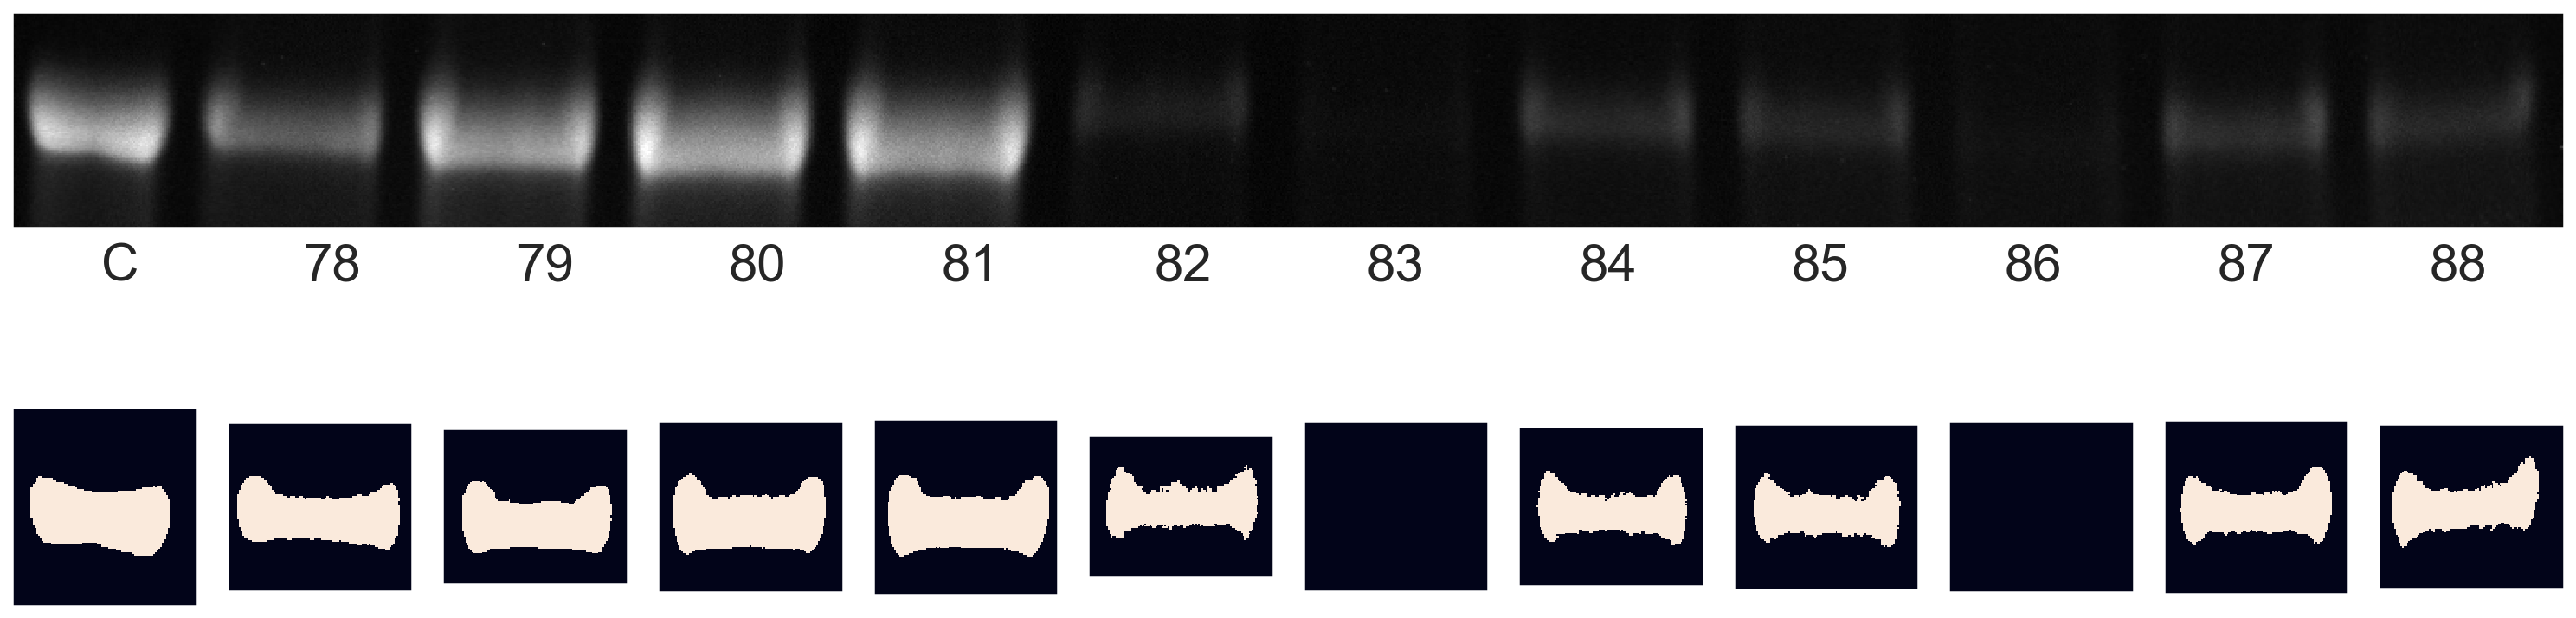

In [16]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h38m28s(Stain Free Gel) 200829 tfxn med r 78-88.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (6432), equivalent to an approximate bitdepth of 12.7.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1060), equivalent to an approximate bitdepth of 10.0.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (2757), equivalent to an approximate bitdepth of 11.4.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (6083), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 111
Number of individual regions =  29
Number of individual regions after small object deletion =  1
Total band intensity = 6
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 31
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 129
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 121
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 128
111
111

6
111

31
111

129
111

121
111

128
111

1.8288063264697105


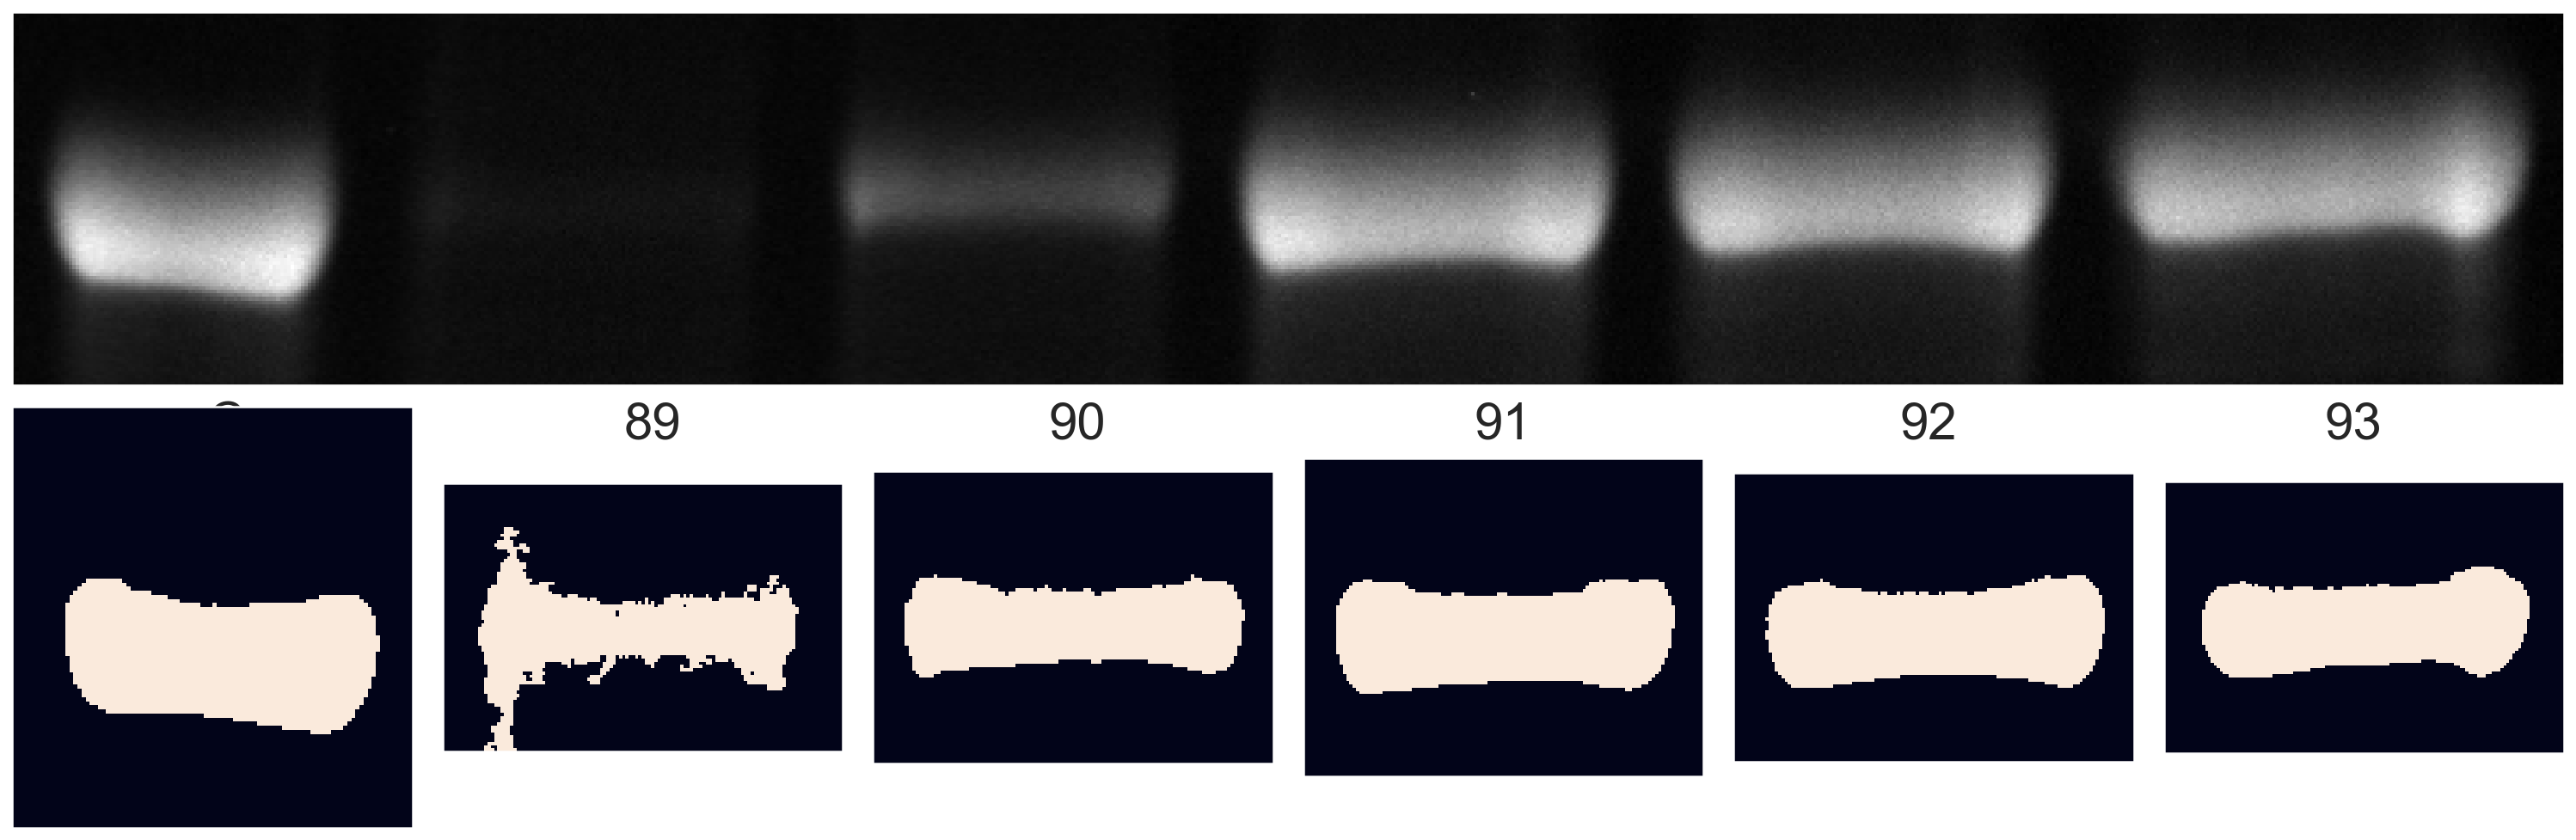

In [17]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h40m21s(Stain Free Gel) 200829 tfxn med r 89-93.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '89',
 '90',
 '91',
 '92',
 '93'], 
                                                      sample_ul=15)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (6357), equivalent to an approximate bitdepth of 12.6.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4254), equivalent to an approximate bitdepth of 12.1.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (3775), equivalent to an approximate bitdepth of 11.9.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (4604), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 107
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 72
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 55
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 78
Number of individual regions =  3
Number of individual regions after small object deletion =  1
Total band intensity = 8
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 43
Number of individual regions =  14
Number of individual regions after small object deletion =  1
Total band intensity = 17
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 95
Number of individual re

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1974), equivalent to an approximate bitdepth of 10.9.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))


 1
Number of individual regions after small object deletion =  1
Total band intensity = 24
107
107

72
107

55
107

78
107

8
107

43
107

17
107

95
107

12
107

24
107

111
107

24
107

1.8288063264697105


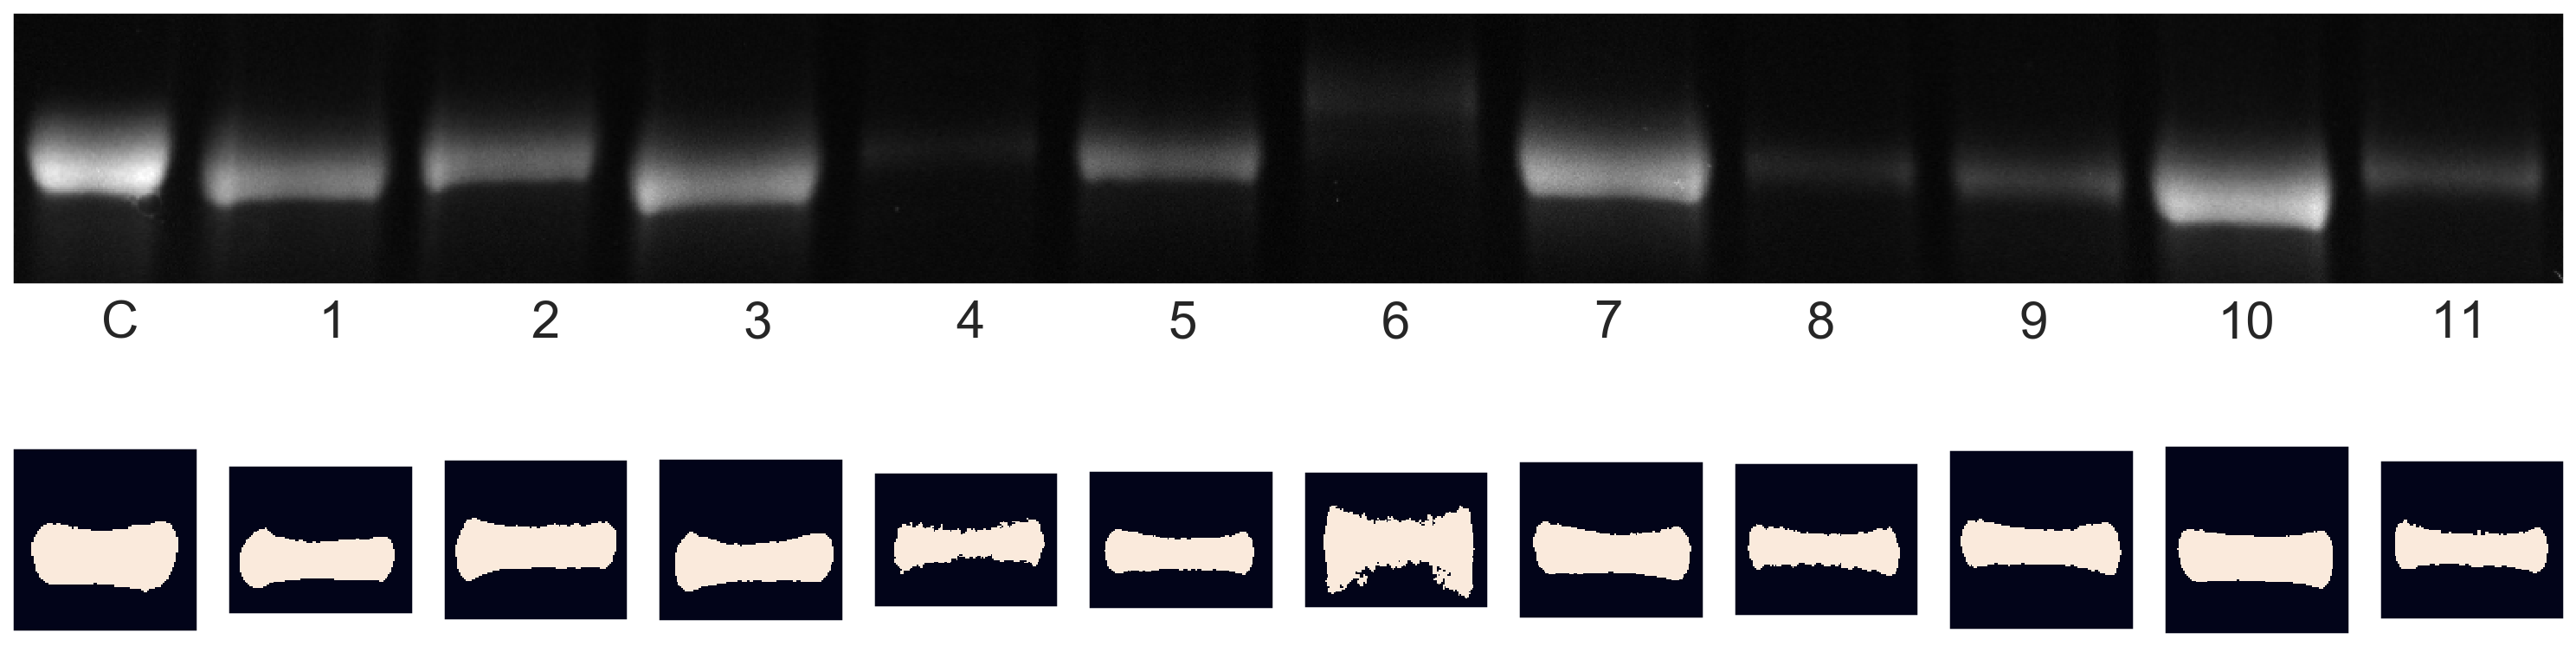

In [18]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h42m24s(Stain Free Gel) 200829 tfxn med nr 1-11.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11'], 
                                                      sample_ul=15)

In [6]:
data

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93']

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (5952), equivalent to an approximate bitdepth of 12.5.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1797), equivalent to an approximate bitdepth of 10.8.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1421), equivalent to an approximate bitdepth of 10.5.
  "bitdepth of {:.1f}.".format(n_bins, np.log2(n_bins)))
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:104: UserWarning: Bad rank filter performance is expected due to a large number of bins (1966), equi

Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 105
Number of individual regions =  13
Number of individual regions after small object deletion =  1
Total band intensity = 6
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 12
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 23
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 11
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 39
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 24
Number of individual regions =  1
Number of individual regions after small object deletion =  1
Total band intensity = 115
105
105

6
105

12
105

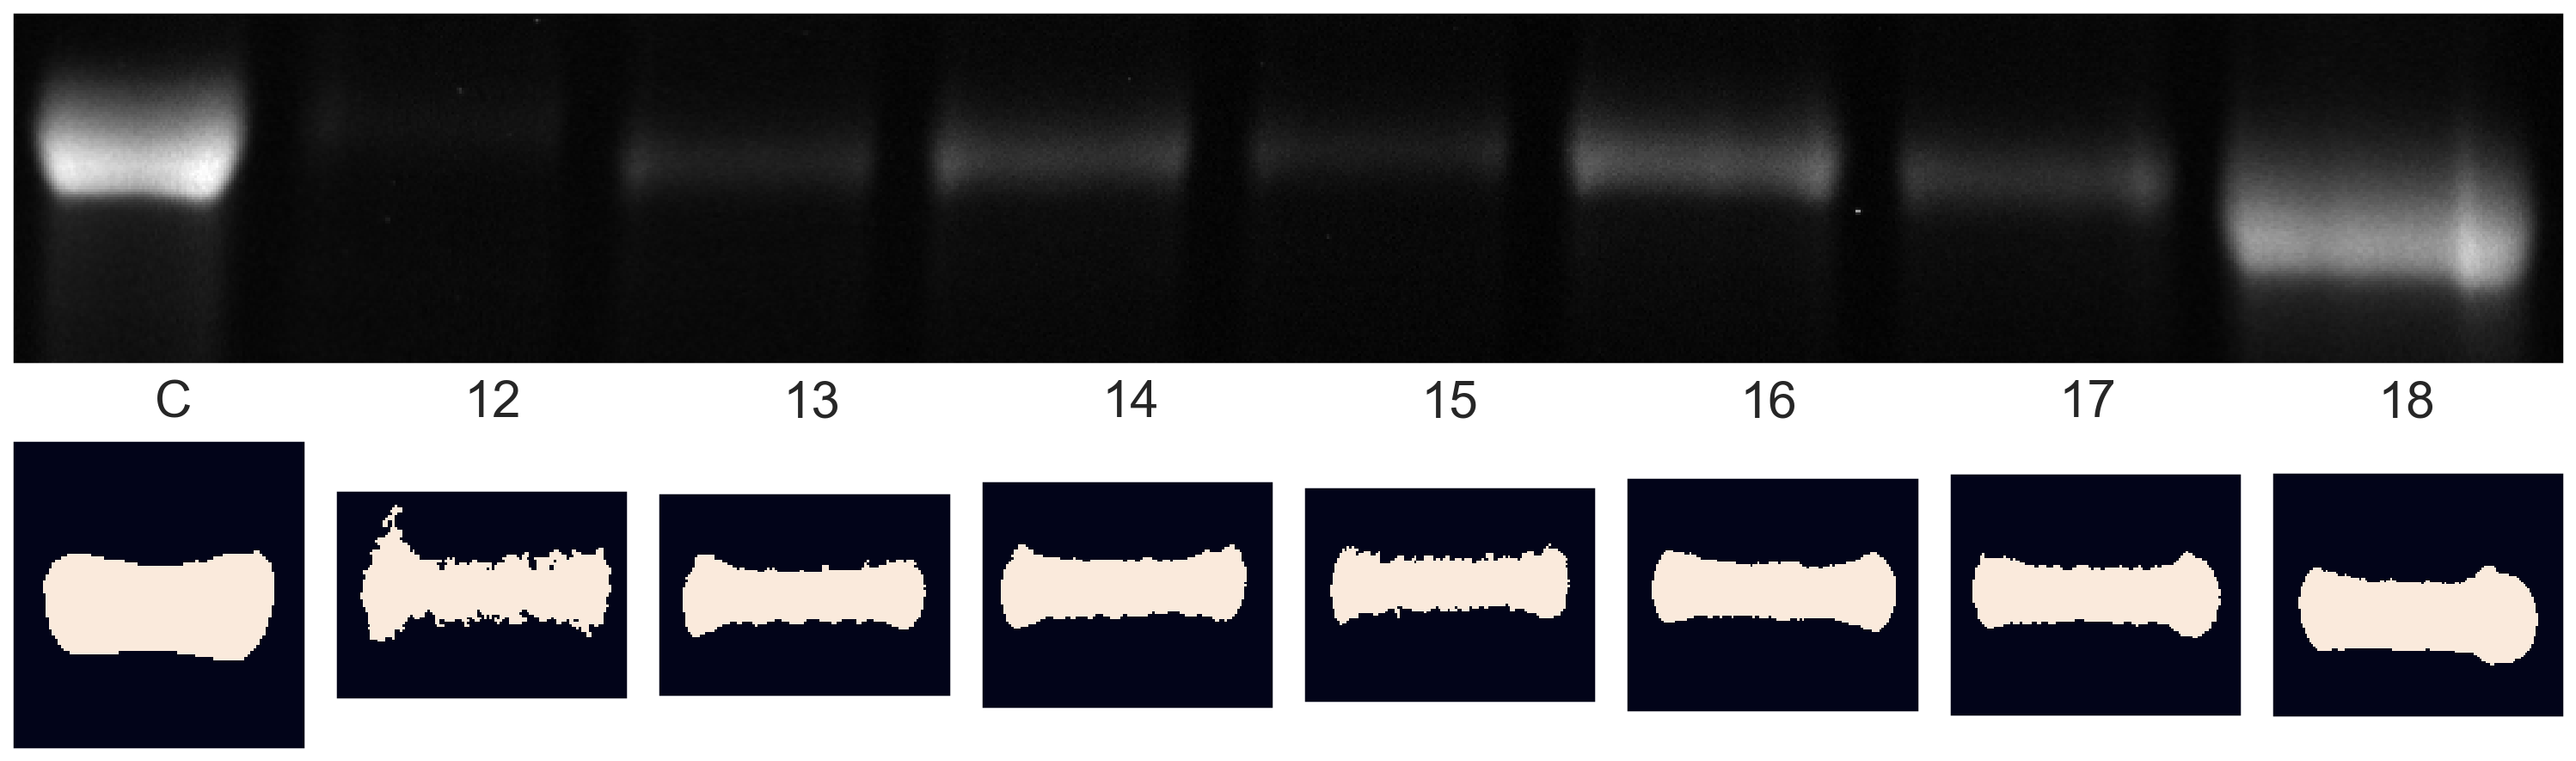

In [19]:
# William 2019-09-28 17h03m00s(Stain Free Gel).raw16.tif
band_name, band_ints, norm_ints = process_protein_gel(image_name = 'William 2020-09-02 15h44m21s(Stain Free Gel) 200829 tfxn med nr 12-18.raw16.tif', 
                                       band_range = (1, 12), ctrl_band = 1, mode = 'sub', 
                                                      label = ['C', '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18'], 
                                                      sample_ul=15)